# Analysis for Build Components, CogSci 2024

In [ ]:
import os
import sys
import urllib, io
import pickle

import random
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances, f1_score

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils
import domino_settings as dominoes
import domino_settings_monochrome as mono_dominoes

import importlib


In [2]:
experiment_name = 'build_components/cogsci24'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots/')
# csv_dir = os.path.join(experiment_results_dir,'csv')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)
    
# if not os.path.exists(plot_dir):
#     os.makedirs(plot_dir)   
    
# if not os.path.exists(csv_dir):
#     os.makedirs(csv_dir)       

## utils

In [3]:
def parallel_bootstrap(df, 
                        bootstrap_column = 'gameID',
                        condition_column = 'condition',
                        value_columns = ['response_correct'],
                        n_iter = 1000,
                        seed = 0,
                        stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic while 
    keeping values of the bootstrapped column consistent across sample distributions.
    This can be used to e.g. sample the same participants in each iteration number.
    '''

    random.seed(seed)
    
    dists = {}
    empirical_stat = {}

    if condition_column != None:
        conditions = df[condition_column].unique()
    else:
        conditions = None

    grouped = df.groupby([bootstrap_column] + [condition_column])
    groups = df[bootstrap_column].unique()
    n_groups = df[bootstrap_column].nunique()

    grouped_stat = grouped[value_columns].apply(stat) 

    for condition in conditions:
        dists[condition] = []
        empirical_stat[condition] = np.mean(grouped_stat.loc[[(group, condition) for group in groups]])
        

    for i in range(n_iter):

        sample = random.choices(groups, k=n_groups)

        for condition in conditions:
            sample_values = grouped_stat.loc[[(group, condition) for group in sample]]
            sample_mean = np.mean(sample_values)
            dists[condition].append(sample_mean)

    
    return dists, empirical_stat

def bootstrap(df, bootstrap_column = 'gameID', condition_columns = ['condition'], value_columns = ['response'], n_iter = 1000, stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic.
    '''
    
    aggregate_values = [] # list of means of statistic for each sample


    df_build_dists_baseline_all = pd.DataFrame()
    grouped = df.groupby([bootstrap_column] + condition_columns)
    groups = df[bootstrap_column].unique()
    grouped_stat = grouped[value_columns].apply(stat) # apply statistic to each group 

    for i in range(n_iter):
        # sample groups to get list of statistics
        sample = grouped_stat.sample(n=grouped.ngroups, replace=True).reset_index(drop=True)
        
        aggregate_values.append(np.mean(sample))
    
    return aggregate_values

def bootstrapped_ci(data, conf_level=0.95):
    lower_bound = np.percentile(data, 100*(1-conf_level)/2)
    upper_bound = np.percentile(data, 100-100*(1-conf_level)/2)
    return lower_bound, upper_bound

def print_result(dist, empirical, conf_level=0.95):
    ci = bootstrapped_ci(dist, conf_level=conf_level)
    print('(${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(empirical, *ci))
    

def p_val(dist1, dist2):
    
    assert(len(dist1) == len(dist2))
    
    p = sum(np.array(dist1) < np.array(dist2)) / len(dist1)
    
    return p


def ci_errorbar_values(dists, mean_dict, order = ['foil','build','view']):
    
    ci_lower = []
    ci_upper = []
    means = []
    
    for condition in order:
        ci = bootstrapped_ci(dists[condition])
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])
    
    means = [mean_dict[condition] for condition in order]
    
    ci_error = [[mean - lower for mean, lower in zip(means, ci_lower)],
                [upper - mean for mean, upper in zip(means, ci_upper)]]
    
    
    return {'means': means, 'error_diffs' : ci_error}


# Calculate 95% CI for each group
def create_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    
#     print('[{:.3g}, {:.3g}]'.format(mean - ci, mean + ci))
    
    return mean - ci, mean + ci

In [4]:
### Extra block utils

def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def mean_tower(group):
    return np.mean(group['square_map'])

In [274]:
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})
import poster_plot_settings
from poster_plot_settings import palette

bar_width = 0.8
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (4, 6)  # Width, Height in inches

In [6]:
# import stim dataframes
df_towers = pd.read_csv('../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')
df_towers['tower_id'] = df_towers.tower_id_tall

In [7]:
condition_order = ['foil','build','view']

# Experiment 1: Recognition

In [275]:
# which iteration name should we use?

iteration_name = 'build_components_pilot_2'

recog_results_dir = results_dir + '/recognition'

### Load csvs from dataframe generator

df_trial = pd.read_csv(recog_results_dir + '/csv/df_trial_{}.csv'.format(iteration_name))

df_recog = df_trial[df_trial.trial_type == "block-tower-old-new"].reset_index().drop(columns=['index', 'Unnamed: 0'])

df_encode = df_trial[~(df_trial.trial_type == "block-tower-old-new")].reset_index().drop(columns=['index', 'Unnamed: 0'])

df_blocks = pd.read_csv(recog_results_dir + '/csv/df_blocks_{}.csv'.format(iteration_name))

In [276]:
df_recog = df_recog.merge(df_towers[['tower_id','stim_wide']], on = 'tower_id')
df_recog['square_map'] = df_recog['stim_wide'].apply(lambda x: get_block_map(x))

### add columns

In [277]:
df_recog['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog.condition]

In [278]:
# double check accuracy calculations
df_recog['response_correct_recalc'] = ((df_recog.response_meaning == 'new') & (df_recog.condition == 'foil')) | \
                                       ((df_recog.response_meaning == 'old') & (df_recog.condition != 'foil'))

df_recog['response_correct_recalc'].equals(df_recog['response_correct'].astype(bool))

True

In [279]:
df_recog['responded_old'] = df_recog.response_meaning.apply(lambda x: 1 if x=='old' else 0)

In [280]:
# Export for stats
save = False

if save:
    filename = '../../../results/recognition/csv/df_recog_vss.csv'
    df_recog.to_csv(filename)
    print(filename)

### response/ recognition accuracy

In [281]:
# bootstrap distributions of mean response
# keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists, response_means = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'condition',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

In [282]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['foil'], *bootstrapped_ci(response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['build'], *bootstrapped_ci(response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['view'], *bootstrapped_ci(response_dists['view'])))


# p_val(dists['view'], dists['build'])

print(p_val(response_dists['view'], response_dists['build']))
print(p_val(response_dists['build'], response_dists['foil']))
print(p_val(response_dists['view'], response_dists['foil']))

foil ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
build ($0.59,\ 95\%\ CI: [0.527,\ 0.653]$)
view ($0.743,\ 95\%\ CI: [0.683,\ 0.793]$)
0.0
0.0
0.0


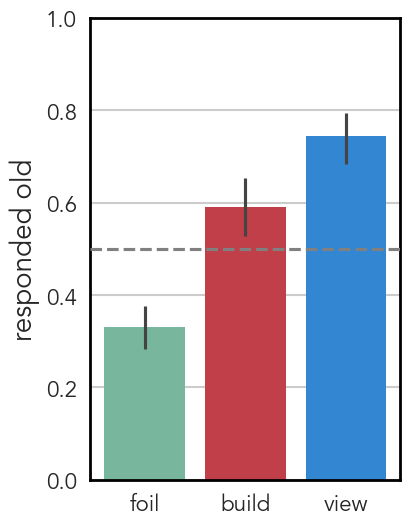

In [420]:
fig = plt.figure()

sns.barplot(data = df_recog, 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
#             yerr = ci_error,
            palette=palette)

cis = ci_errorbar_values(response_dists, 
                         response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
    
plt.savefig(plot_dir + 'recog_response.pdf', bbox_inches='tight')

# plt.show()

#### old vs. new stimuli

In [284]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists_novelty, response_means_novelty = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['old'], *bootstrapped_ci(response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['new'], *bootstrapped_ci(response_dists_novelty['new'])))
print(p_val(response_dists_novelty['old'], response_dists_novelty['new']))

old ($0.667,\ 95\%\ CI: [0.62,\ 0.708]$)
new ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
0.0


### Encoding

In [285]:
# build time
df_encode.loc[:,'relative_time_s'] = df_encode.relative_time / 1000

time_dist, mean_time =  parallel_bootstrap(df_encode[df_encode.condition == 'build'],
                                           condition_column='condition',
                                           value_columns=['relative_time_s']
                                          )

print_result(time_dist['build'], mean_time['build'])

($61.1,\ 95\%\ CI: [53.5,\ 69.2]$)


# Experiment 2: Recall

Some dataframe names are shared with previous section. Run entire section at a time.

In [286]:
iteration_name = 'build_components_build_recall_prolific_pilot_6_towers_2_rep'


recall_results_dir = results_dir + '/recall'

df_encode = pd.read_csv(recall_results_dir + '/df_learn_{}.csv'.format(iteration_name))
df_trial = pd.read_csv(recall_results_dir + '/df_trial_{}.csv'.format(iteration_name))
df_recall_trial = pd.read_csv(recall_results_dir + '/df_recall_trial_{}.csv'.format(iteration_name))
df_recalled_towers = pd.read_csv(recall_results_dir + '/df_recalled_towers_{}.csv'.format(iteration_name))
df_blocks = pd.read_csv(recall_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

In [287]:
df_encode = df_encode.merge(df_towers[['tower_id','stim_wide']], how='left', on = 'tower_id')
df_encode['square_map'] = df_encode['stim_wide'].apply(lambda x: get_block_map(x))

In [288]:
df_recalled_towers['tower_details'] = df_recalled_towers.towerDetails.apply(ast.literal_eval)
df_recalled_towers['alignedTowerBlocks'] = df_recalled_towers.alignedTowerBlocks.apply(ast.literal_eval)
df_encode['stimulus'] = df_encode.stimulus.apply(ast.literal_eval)

In [289]:
# remove duplicate towers

# find block map aligned to left
df_recalled_towers['alignedBlockMaps'] = \
    df_recalled_towers['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalled_towers['alignedBlockMapsHashable'] = df_recalled_towers['alignedBlockMaps'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# consider towers the same if their corresponding block maps are identical
df_recalled_towers_unique = df_recalled_towers.sort_values(['nTower']).groupby(['gameID', 'alignedBlockMapsHashable']).first().reset_index()

print("removed {} duplicate towers".format(len(df_recalled_towers) - len(df_recalled_towers_unique)))

removed 7 duplicate towers


In [290]:
def tower_width(block_map):
    index = np.argmax(np.where(block_map.sum(0) > 0))
    width = index + 1 # a little hacky- but should be fine
    return width

max_recall_width = df_recalled_towers_unique['alignedBlockMaps'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_width + stim_width)))

widest recalled tower is of width 7
world for calculating max f1 score must 11 wide


In [291]:
def tower_height(block_map):
    index = np.argmax(np.where(block_map.sum(1) > 0))
    height = index + 1
#     height = index + 1 # a little hacky- but should be fine
    return height

max_recall_height = df_recalled_towers_unique['alignedBlockMaps'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_height + stim_height)))

tallest recalled tower is of height 8
world for calculating max f1 score must 14 wide


In [292]:
df_encode['alignedBlockMaps'] = df_encode['stimulus'].apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

df_encode['alignedBlockMapsHashable'] = df_encode['alignedBlockMaps'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

In [293]:
def pad_array(arr, n_col, side="left"):
    # Number of rows in the array
    n_rows = arr.shape[0]

    # Create a column of 0s with the same number of rows
    zeros_column = np.zeros((n_rows, n_col))

    # Add the column of 0s to the right side of the array
    if side =="left":
        new_arr = np.hstack((zeros_column, arr))
    elif side =="right":
        new_arr = np.hstack((arr, zeros_column))
    else:
        raise(Exception)

    return new_arr


In [294]:
# add padding to left (max width of recall)
df_encode['paddedBlockMaps'] = df_encode['alignedBlockMaps'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap )
right_padding = max(0, max_recall_width-6)
df_encode['paddedBlockMaps'] = df_encode['paddedBlockMaps'].apply(lambda x: pad_array(x, right_padding, side="right"))

df_recalled_towers_unique['paddedBlockMaps'] = df_recalled_towers_unique['alignedBlockMaps'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))

In [295]:
def translate_tower(arr, dx, dy, fill_value = 0):
    """
    Translate a 2D NumPy array along the x and y axes.

    Args:
        arr (numpy.ndarray): 2D NumPy array.
        dx (int): Number of positions to translate along the x-axis.
        dy (int): Number of positions to translate along the y-axis.

    Returns:
        numpy.ndarray: Translated 2D NumPy array.
    """
    rows, cols = arr.shape
    translated_arr = np.full((rows, cols), fill_value)

    x_start = max(0, dx)
    x_end = cols + min(0, dx)
    y_start = max(0, dy)
    y_end = rows + min(0, dy)

    src_x_start = max(0, -dx)
    src_x_end = cols + min(0, -dx)
    src_y_start = max(0, -dy)
    src_y_end = rows + min(0, -dy)

    translated_arr[y_start:y_end, x_start:x_end] = arr[src_y_start:src_y_end, src_x_start:src_x_end]

    return translated_arr

In [296]:
def f1(arr1, arr2):
    assert arr1.shape == arr2.shape, "The input arrays must have the same shape"
    return f1_score(arr1.ravel(), arr2.ravel())

def iou(arr1, arr2):
    assert arr1.shape == arr2.shape, "The input arrays must have the same shape"
    return jaccard_score(arr1.ravel(), arr2.ravel())


def best_score(target_tower, recalled_tower, scoring_fn = iou, render = False):
    '''
    Holds target_tower still, and tiles recalled_tower to find the best alignment that maximizes measure.
    Args:
        target_tower and recalled_tower: two arrays of equal dimensions
    
    Returns:
        maximum f1 score
    '''
    
    assert(np.array_equal(target_tower.shape, recalled_tower.shape))
    
    max_score = 0
    best_transformed = None
    overlay_map = None
    best_dx, best_dy = None, None
    
    dy = 0 # only allows dx translation right now
    
    for dx in range(0, target_tower.shape[0]):
        transformed_arr = translate_tower(recalled_tower, dx, dy)
        score = scoring_fn(target_tower, transformed_arr)
        if score > max_score:
                max_score = score
                best_transformed = transformed_arr
                overlay_map = transformed_arr + target_tower*3
                best_dx, best_dy = dx, dy

    if render:
        fig = plt.figure()
        plt.imshow(overlay_map, cmap='inferno')
        fig.gca().axis('off')

                
    return max_score, best_transformed, (best_dx, best_dy)


def get_score_matrix(targets, recalls, distance_measure=best_score, render = False):
    '''
    Returns distance matrix between 
    '''

    scores = targets.apply(lambda target: 
                recalls.apply(lambda recall: 
                    distance_measure(target['paddedBlockMaps'], recall['paddedBlockMaps'], render=render)[0], # just get score
                    axis=1),
                axis=1)

    return scores

def get_aligned_reconstructions(targets, recalls, distance_measure=best_score, render = False):
    '''
    Returns block maps of reconstructions aligned to stims
    '''

    scores = targets.apply(lambda target: 
                recalls.apply(lambda recall: 
                    distance_measure(target['paddedBlockMaps'], recall['paddedBlockMaps'], render=render)[1], # just get score
                    axis=1),
                axis=1)

    return scores

from scipy.optimize import linear_sum_assignment

def maximal_mapping(distance_matrix):
    '''
    Takes a distance matrix and returns the assignment that maximizes the total score
    '''
    # returns a list, as long as the amount of columns, with each containing a row index
    # i.e. this will find the mapping of columns (recalls) to rows (targets), though not every row need be assigned to a target
    row_ind, col_ind = linear_sum_assignment(distance_matrix, maximize=True)
#     sorted_matrix = distance_matrix[:, optimal_assignment]
    return row_ind, col_ind

# hack to store arrays as elements
class AlignedBlockMap:
    def __init__(self, arr):
        self.arr = arr

In [297]:
df_recalled_towers_unique['bestMatch'] = 'unassigned'
df_recalled_towers_unique['bestMatchScore'] = np.NaN
df_recalled_towers_unique['bestMatchCondition'] = 'unassigned'
df_recalled_towers_unique['bestMatchAlignment'] = 'unassigned'

# df_recalled_towers_unique['bestMatchAlignment'] = df_recalled_towers_unique['bestMatchAlignment'].astype(object)

In [298]:
gameIDs = df_encode.gameID.unique()

# for each participant
for gameID in gameIDs:
    
    # find stimuli
    df_ppt_learn = df_encode[(df_encode.gameID == gameID)].groupby('tower_id').first()
    
    assert(len(df_ppt_learn) == 6)
    
    # find recalled towers
    df_ppt_recall = df_recalled_towers_unique[df_recalled_towers_unique.gameID == gameID].groupby("nTower").first()
    
    ppt_scores = get_score_matrix(df_ppt_learn, df_ppt_recall)
    ppt_maps = get_aligned_reconstructions(df_ppt_learn, df_ppt_recall)
    
    # calculate optimal assignment
    row_ind, col_ind = maximal_mapping(ppt_scores)
    
    assignment_dict = dict(zip(df_ppt_recall.index[col_ind], ppt_scores.index[row_ind]))
    
    for i, (nTower, towerID) in enumerate(assignment_dict.items()):
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatch'] = towerID
        
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchScore'] = \
                        ppt_scores.loc[towerID,nTower]
        
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchAlignment'] =\
                        AlignedBlockMap(ppt_maps.loc[towerID, nTower])

        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchCondition'] = \
                        df_ppt_learn.loc[towerID,'condition']
    

In [299]:
df_recalled_towers_unique['bestMatchAlignment'] = df_recalled_towers_unique['bestMatchAlignment'].apply(lambda x: x.arr)

In [300]:
def showDiscreteMap(row, ax, vmax=None, **kwargs):
#     world_maps = df.apply(lambda row: row)
    n = row.shape[0]
    av_map = np.add.reduce(np.array(row))/n
#     av_map = np.add.reduce(np.array(row))
#     av_map = np.rot90(av_map)/n
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                **kwargs)
    else:
        ax.imshow(av_map,
                **kwargs)

In [301]:
stim_maps = df_encode.groupby('tower_id').first().reset_index()[['tower_id','paddedBlockMaps']]

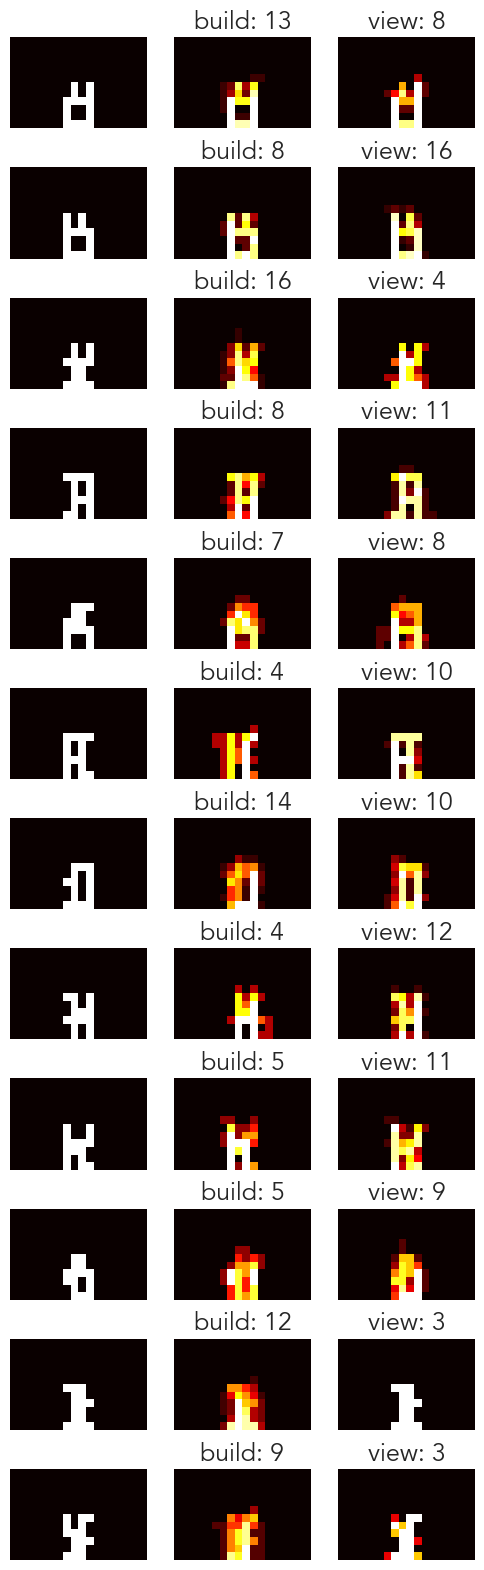

In [302]:
tower_ids = df_recalled_towers_unique.bestMatch.unique()

fig, axs = plt.subplots(nrows=len(tower_ids), ncols=3, figsize=(6, 20))  

for (i, tower_id) in enumerate(tower_ids):
    axs[i,0].axis('off')
    showDiscreteMap(stim_maps[(stim_maps.tower_id == tower_id)]['paddedBlockMaps'], 
                    axs[i, 0],
                    cmap= 'hot',)

for (j, condition) in enumerate(['build','view']):
    for (i, tower_id) in enumerate(tower_ids):
        subset = df_recalled_towers_unique[(df_recalled_towers_unique.bestMatch == tower_id) & 
                                                  (df_recalled_towers_unique.bestMatchCondition == condition)]['bestMatchAlignment']
        axs[i,j+1].axis('off')
        axs[i,j+1].set_title(condition + ': ' + str(len(subset)))
        showDiscreteMap(subset, 
                        axs[i, j+1],
                        cmap= 'hot',)

plt.savefig('heatmaps.pdf', format='pdf')

In [303]:
# group the DataFrame by 'gameID' and 'bestMatchCondition', and count the rows
grouped = df_recalled_towers_unique.groupby(['gameID','bestMatchCondition']).agg({'experimentName':'count',
                                                                                 'bestMatchScore':'mean'})
# Get all unique values for each column
gameIDs = df_recalled_towers_unique['gameID'].unique()
conditions = df_recalled_towers_unique['bestMatchCondition'].unique()

# Create a DataFrame with all possible combinations of the unique values
all_combinations = pd.MultiIndex.from_product([gameIDs, conditions], names=['gameID', 'bestMatchCondition']).to_frame(index=False)

# Merge the DataFrame with all combinations and the grouped DataFrame
merged = all_combinations.merge(grouped, on=['gameID', 'bestMatchCondition'], how="left")

merged['experimentName'] = merged['experimentName'].fillna(0)
merged['bestMatchScore'] = merged['bestMatchScore'].fillna(np.NaN)
merged = merged.rename(columns={'experimentName':'nMatched',
                       'bestMatchScore':'bestMatchScoreMean'})

bestMatchConditionCounts = merged

In [304]:
# leave out participants who don't have at least one recall tower in each condition. find diff between f1. 
# Do paired t-test.

def built_both(df):
    built = df.loc[df.bestMatchCondition == 'build','nMatched'].iloc[0]
    viewed = df.loc[df.bestMatchCondition == 'view','nMatched'].iloc[0]
    
    both = (built > 0) & (viewed > 0)
    
    return both

built_both = bestMatchConditionCounts.groupby(['gameID']).apply(lambda group: built_both(group))

bestMatchConditionCounts.loc[:,'built_both'] = bestMatchConditionCounts.gameID.isin(list(built_both[built_both].index))

In [305]:
bestMatchConditionCounts

,gameID,bestMatchCondition,nMatched,bestMatchScoreMean,built_both
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,build,3.0,0.925926,True
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,view,3.0,0.684848,True
2,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,build,2.0,0.727273,True
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,view,2.0,0.703081,True
4,0617-9ddb7997-5774-4c33-849a-ab70289df180,build,0.0,NaN,False
...,...,...,...,...,...
95,9343-013fb2db-94d6-4c42-b102-167d834d6e0b,view,1.0,1.000000,True
96,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,build,3.0,0.661933,True
97,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,view,3.0,0.707937,True
98,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,build,2.0,0.684211,True


In [306]:
bestMatchConditionCounts.to_csv('{}/recall/csv/df_best_match_recalls_vss.csv'.format(results_dir))

In [307]:
#### construct dataframe where each stimulus gets all the information about the best matching recall tower

df_encode_unique = df_encode[df_encode.rep==1].reset_index(drop=True)
df_encode_unique_paired = df_encode_unique.merge(df_recalled_towers_unique, 
                                               how='left', 
                                               left_on=['gameID','tower_id'], 
                                               right_on=['gameID','bestMatch']).reset_index(drop=True)
                      
default_values = {
    'C_id': -1,     # default for C_id
    'bestMatch': 'no_match',     # default for D_id
    'bestMatchScore': 0,
    'perfectMatch': False
    
#     'value2': 'default_value'  # default for value2
}

df_encode_unique_paired.fillna(value=default_values, inplace=True)

for threshold in list(np.arange(0.1,1,0.05)):
    df_encode_unique_paired.loc[:, f'matched_meeting_threshold_{threshold:.2f}'] = df_encode_unique_paired['bestMatchScore'] > threshold
    
df_encode_unique_paired.loc[:, 'matched_to_any'] = df_encode_unique_paired['bestMatchScore'] > 0

In [308]:
df_encode_unique_paired.loc[:,'perfectMatch'] = df_encode_unique_paired.bestMatchScore == 1
df_encode_unique_paired.loc[:,'perfectly_recalled'] = df_encode_unique_paired.bestMatchScore == 1

### Stats on recall

Linear models are run in the Rmd.

#### Number of matched towers

In [309]:
# df_learn_unique_paired.to_csv('{}/df_learn_unique_paired.csv'.format(experiment_results_dir))
df_encode_unique_paired.to_csv('{}/recall/csv/df_encode_with_recalls_vss.csv'.format(results_dir))

In [508]:
# number of towers
df_all_unique_recalls = df_encode_unique_paired.groupby(['condition','gameID'])['matched_to_any'].sum().reset_index()
df_all_unique_recalls.loc[:,'all'] = 'all'

all_recall_dist, all_recall_mean = parallel_bootstrap(df_all_unique_recalls,
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['matched_to_any'],
                   stat = np.sum
                  )

print('(${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(all_recall_mean['all'], *bootstrapped_ci(all_recall_dist['all'])))


($4.2,\ 95\%\ CI: [3.7,\ 4.64]$)


In [512]:
# number of towers by condition
condition_recall_dist, condition_recall_mean = parallel_bootstrap(df_all_unique_recalls,
                   bootstrap_column = 'gameID',
                   condition_column = 'condition',
                   value_columns = ['matched_to_any'],
                   stat = np.sum,
                   seed = 0
                  )

print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(condition_recall_mean['build'], *bootstrapped_ci(condition_recall_dist['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(condition_recall_mean['view'], *bootstrapped_ci(condition_recall_dist['view'])))

print(p_val(condition_recall_dist['view'], condition_recall_dist['build']))

build ($2.1,\ 95\%\ CI: [1.82,\ 2.34]$)
view ($2.1,\ 95\%\ CI: [1.8,\ 2.38]$)
0.44


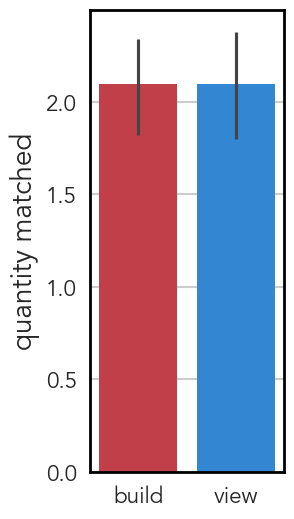

In [321]:
# sums of perfect reconstructions by condition

fig = plt.figure(figsize=(2.5,6))

sns.barplot(data = df_all_unique_recalls,
                y = "matched_to_any",
                x = "condition",
                hue = "condition",
                order = ['build','view'],
                palette = palette,
                errorbar=None,
                width=bar_width
#                 yerr = cis
           )

cis = ci_errorbar_values(condition_recall_dist, 
                         condition_recall_mean, 
                         order = ['build','view'])

plt.errorbar(y = cis['means'], 
             x = [0,1], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

# plt.title("number of perfect recalls")
plt.ylabel("quantity matched")
plt.xlabel("")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

plt.savefig(plot_dir + 'recall_n_matched_recalls.pdf', bbox_inches='tight')

#### Number of matched towers that were perfect reconstructions

In [537]:
df_all_perfs = df_encode_unique_paired.groupby(['gameID'])['perfectMatch'].sum().reset_index()
df_all_perfs.loc[:,'all'] = 'all'

In [538]:
all_perfs_dist, all_perfs_mean = parallel_bootstrap(df_all_perfs,
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['perfectMatch'],
                   stat= np.sum,
                   n_iter = 1000,
                   seed = 0
                  )

In [539]:
print('both (${:.3g}, 95\% CI: [{:.3g}, {:.3g}]$)'.format(all_perfs_mean['all'], *bootstrapped_ci(all_perfs_dist['all'])))


both ($1.46, 95\% CI: [1.06, 1.84]$)


In [313]:
df_perfs = df_encode_unique_paired.groupby(['condition','gameID'])['perfectMatch'].sum().reset_index()
df_perfs.loc[:,'all'] = 'all'

In [531]:
perfs_dist, perfs_mean = parallel_bootstrap(df_perfs,
                   bootstrap_column = 'gameID',
                   condition_column = 'condition',
                   value_columns = ['perfectMatch'],
                   stat= np.sum,
                   n_iter = 1000,
                   seed = 0
                  )

In [532]:
print('build (${:.3g}, 95\% CI: [{:.3g}, {:.3g}]$)'.format(perfs_mean['build'], *bootstrapped_ci(perfs_dist['build'])))
print('view (${:.3g}, 95\% CI: [{:.3g}, {:.3g}]$)'.format(perfs_mean['view'], *bootstrapped_ci(perfs_dist['view'])))


# p_val(dists['view'], dists['build'])

print(p_val(perfs_dist['view'], perfs_dist['build']))

build ($0.56, 95\% CI: [0.34, 0.78]$)
view ($0.9, 95\% CI: [0.62, 1.22]$)
0.02


In [316]:
np.sum(np.array(perfs_dist['view']) - np.array(perfs_dist['build']) < 0)/1000

0.02

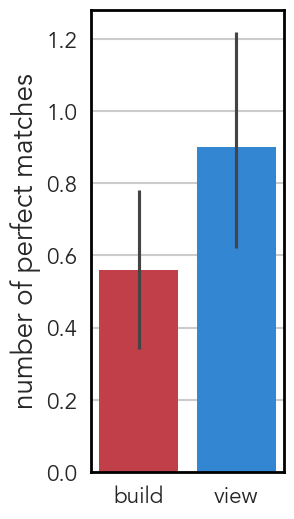

In [322]:
# sums of perfect reconstructions by condition

fig = plt.figure(figsize=(2.5,6))

sns.barplot(data = df_perfs,
                y = "perfectMatch",
                x = "condition",
                hue = "condition",
                order = ['build','view'],
                palette = palette,
                errorbar=None,
                width=bar_width
#                 yerr = cis
           )

cis = ci_errorbar_values(perfs_dist, 
                         perfs_mean, 
                         order = ['build','view'])

plt.errorbar(y = cis['means'], 
             x = [0,1], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

# plt.title("number of perfect recalls")
plt.ylabel("number of perfect matches")
plt.xlabel("")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

plt.savefig(plot_dir + 'recall_n_perf_recalls.pdf', bbox_inches='tight')

#### Accuracy of matched towers (including 0 for non-recalls)

In [318]:
matched_score_dist, matched_score_mean = \
                parallel_bootstrap(df_encode_unique_paired,
                                   bootstrap_column = 'gameID',
                                   condition_column = 'condition',
                                   value_columns = ['bestMatchScore'],
                                   n_iter = 1000,
                                   seed = 0
                                  )

In [319]:
print('build (${:.3g}, 95\% CI: [{:.3g}, {:.3g}]$)'.format(matched_score_mean['build'], *bootstrapped_ci(matched_score_dist['build'])))
print('view (${:.3g}, 95\% CI: [{:.3g}, {:.3g}]$)'.format(matched_score_mean['view'], *bootstrapped_ci(matched_score_dist['view'])))

build ($0.508, 95\% CI: [0.446, 0.569]$)
view ($0.56, 95\% CI: [0.469, 0.642]$)


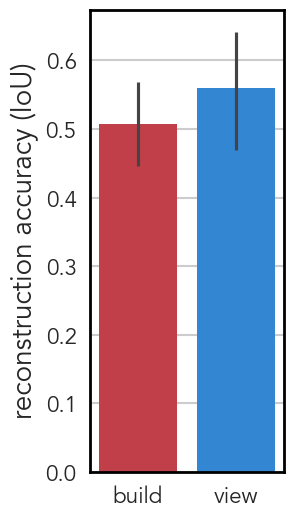

In [456]:
# sums of perfect reconstructions by condition

fig = plt.figure(figsize=(2.5,6))

sns.barplot(data = df_encode_unique_paired,
                y = "bestMatchScore",
                x = "condition",
                hue = "condition",
                order = ['build','view'],
                palette = palette,
                errorbar=None,
                width=bar_width
#                 yerr = cis
           )

cis = ci_errorbar_values(matched_score_dist, 
                         matched_score_mean, 
                         order = ['build','view'])

plt.errorbar(y = cis['means'], 
             x = [0,1], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylabel("reconstruction accuracy (IoU)")
plt.xlabel("")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

plt.savefig(plot_dir + 'recall_accuracy_recalls.pdf', bbox_inches='tight')

#### Accuracy of matched towers meaned within participant, excluding participants who didn't build at least one of each tower

In [344]:
matched_mean_score_dist, matched_mean_score_mean = \
                parallel_bootstrap(bestMatchConditionCounts[bestMatchConditionCounts['built_both']],
                                   bootstrap_column = 'gameID',
                                   condition_column = 'bestMatchCondition',
                                   value_columns = ['bestMatchScoreMean'],
                                   n_iter = 1000,
                                   seed = 0
                                  )

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_30998/4145125674.py:27: UserWarning: 
The palette list has fewer values (1) than needed (50) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data = bestMatchConditionCounts,


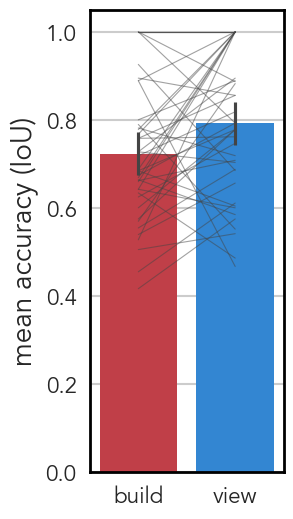

In [458]:
# sums of perfect reconstructions by condition

fig = plt.figure(figsize=(2.5,6))

sns.barplot(data = bestMatchConditionCounts[bestMatchConditionCounts['built_both']],
                y = "bestMatchScoreMean",
                x = "bestMatchCondition",
                hue = "bestMatchCondition",
                order = ['build','view'],
                palette = palette,
                errorbar=None,
                width=bar_width
#                 yerr = cis
           )

cis = ci_errorbar_values(matched_mean_score_dist, 
                         matched_mean_score_mean, 
                         order = ['build','view'])

plt.errorbar(y = cis['means'], 
             x = [0,1], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')


sns.pointplot(data = bestMatchConditionCounts,
                y = "bestMatchScoreMean",
                x = "bestMatchCondition",
                hue = "gameID",
                order = ['build','view'],
                markers='',
                linewidth=0.8,
#                 linecolor='grey'
                palette = ['#444444'],
                alpha = 0.5,
#                 yerr = cis
           )

plt.ylabel("mean accuracy (IoU)")
plt.xlabel("")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

plt.savefig(plot_dir + 'recall_mean_accuracy_recalls.pdf', bbox_inches='tight')

# Experiment 3 + 4 read in data

In [20]:
# final iteration names are suffixes of csvs

csv_ids = {
    "ve_on" : "build_components_cogsci_ve_old_new_prolific_pilot_0",
    "ve_re": "build_components_cogsci_ve_recall_prolific_pilot_0",
    "wm_on" : "build_components_cogsci_wm_old_new_prolific_pilot_0",
    "wm_re": "build_components_cogsci_wm_recall_prolific_pilot_0"
}

experiment_results_dir

'/Users/will/zipping/results/build_components/cogsci24'

In [21]:
# read in all dataframes

dfs = {}

for i, (k, v) in enumerate(csv_ids.items()):
    dfs[k] = {}
    dfs[k]['encode'] = pd.read_csv(experiment_results_dir + '/df_encode_{}.csv'.format(v))
    dfs[k]['decode'] = pd.read_csv(experiment_results_dir + '/df_decode_{}.csv'.format(v))
    dfs[k]['block'] = pd.read_csv(experiment_results_dir + '/df_block_{}.csv'.format(v))
    dfs[k]['construct'] = pd.read_csv(experiment_results_dir + '/df_construction_procedure_{}.csv'.format(v))
    
dfs['ve_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['ve_re']))
dfs['wm_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['wm_re']))

In [22]:
def exclude_ppts(dfg, excluded):
    dfg['encode'] = dfg['encode'][~dfg['encode'].gameID.isin(excluded)].reset_index()
    dfg['decode'] = dfg['decode'][~dfg['decode'].gameID.isin(excluded)].reset_index()
    dfg['block'] = dfg['block'][~dfg['block'].gameID.isin(excluded)].reset_index()
    dfg['construct'] =dfg['construct'][~dfg['construct'].gameID.isin(excluded)].reset_index()

In [23]:
dfs['ve_on']['decode'].loc[:, 'responded_old'] = dfs['ve_on']['decode'].response_meaning == 'old'
dfs['wm_on']['decode'].loc[:, 'responded_old'] = dfs['wm_on']['decode'].response_meaning == 'old'

# Experiment 3: Encoding type for recognition

In [24]:
# appply exclusion criteria
df = dfs['ve_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

56 ppts to start with
6 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for key mashing
0 ppts removed for waiting too long between phases
50 ppts remaining


In [25]:
# appply exclusion criteria
df = dfs['ve_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

55 ppts to start with
5 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
1 ppts removed for waiting too long between phases
50 ppts remaining


## visual exposure

In [26]:
dfs['ve_on']['decode']['novelty'] = ['new' if condition == 'foil' else 'old' for condition in dfs['ve_on']['decode'].condition]

In [27]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
ve_response_dists, ve_response_means = parallel_bootstrap(dfs['ve_on']['decode'], 
                                                    bootstrap_column = 'gameID',
                                                    condition_column = 'condition',
                                                    value_columns = ['responded_old'],
                                                    n_iter = 1000,
                                                    stat = np.mean)

In [28]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['foil'], *bootstrapped_ci(ve_response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['build'], *bootstrapped_ci(ve_response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['view'], *bootstrapped_ci(ve_response_dists['view'])))

print(p_val(ve_response_dists['view'], ve_response_dists['build']))
print(p_val(ve_response_dists['build'], ve_response_dists['foil']))
print(p_val(ve_response_dists['view'], ve_response_dists['foil']))

foil ($0.29,\ 95\%\ CI: [0.243,\ 0.34]$)
build ($0.78,\ 95\%\ CI: [0.713,\ 0.847]$)
view ($0.833,\ 95\%\ CI: [0.753,\ 0.9]$)
0.173
0.0
0.0


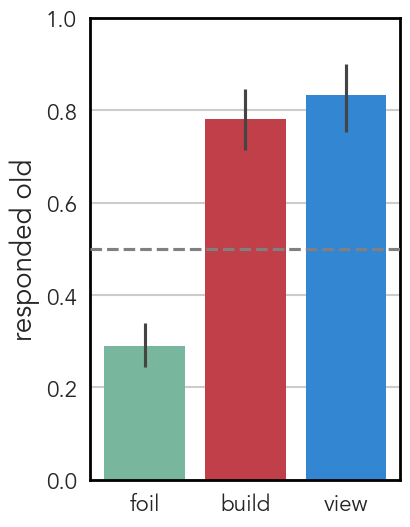

In [419]:
fig = plt.figure()

sns.barplot(data = dfs['ve_on']['decode'], 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
            palette=palette)

cis = ci_errorbar_values(ve_response_dists, 
                         ve_response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.savefig(plot_dir + 'encode_ve_recog_response.pdf', bbox_inches='tight')

plt.show()

In [30]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
ve_response_dists_novelty, ve_response_means_novelty = parallel_bootstrap(dfs['ve_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means_novelty['old'], *bootstrapped_ci(ve_response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means_novelty['new'], *bootstrapped_ci(ve_response_dists_novelty['new'])))

# p_val(dists['view'], dists['build'])

print(p_val(ve_response_dists_novelty['old'], ve_response_dists_novelty['new']))

# df_recog.novelty

old ($0.807,\ 95\%\ CI: [0.76,\ 0.853]$)
new ($0.29,\ 95\%\ CI: [0.243,\ 0.34]$)
0.0


### working memory

In [445]:
dfs['wm_on']['decode']['novelty'] = ['new' if condition == 'foil' else 'old' for condition in dfs['wm_on']['decode'].condition]

In [446]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
wm_response_dists, wm_response_means = parallel_bootstrap(dfs['wm_on']['decode'], 
                                                    bootstrap_column = 'gameID',
                                                    condition_column = 'condition',
                                                    value_columns = ['responded_old'],
                                                    n_iter = 1000,
                                                    stat = np.mean)

In [447]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['foil'], *bootstrapped_ci(wm_response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['build'], *bootstrapped_ci(wm_response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['view'], *bootstrapped_ci(wm_response_dists['view'])))

print(p_val(wm_response_dists['view'], wm_response_dists['build']))
print(p_val(wm_response_dists['build'], wm_response_dists['foil']))
print(p_val(wm_response_dists['view'], wm_response_dists['foil']))

foil ($0.275,\ 95\%\ CI: [0.222,\ 0.33]$)
build ($0.876,\ 95\%\ CI: [0.824,\ 0.922]$)
view ($0.876,\ 95\%\ CI: [0.83,\ 0.915]$)
0.498
0.0
0.0


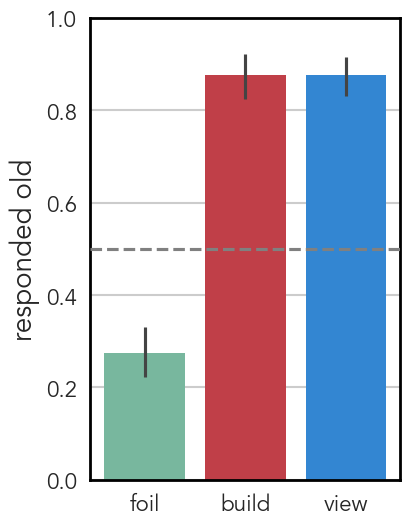

In [448]:
fig = plt.figure()

sns.barplot(data = dfs['wm_on']['decode'], 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
            palette=palette)

cis = ci_errorbar_values(wm_response_dists, 
                         wm_response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.savefig(plot_dir + 'encode_wm_recog_response.pdf', bbox_inches='tight')

plt.show()

In [449]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
wm_response_dists_novelty, wm_response_means_novelty = parallel_bootstrap(dfs['wm_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means_novelty['old'], *bootstrapped_ci(wm_response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means_novelty['new'], *bootstrapped_ci(wm_response_dists_novelty['new'])))

# p_val(dists['view'], dists['build'])

print(p_val(wm_response_dists_novelty['old'], wm_response_dists_novelty['new']))

# df_recog.nowmlty

old ($0.876,\ 95\%\ CI: [0.843,\ 0.908]$)
new ($0.275,\ 95\%\ CI: [0.222,\ 0.33]$)
0.0


### Was performance higher in working memory condition?

#### compare overall accuracy across encoding types

In [ ]:
ve_recog_accuracy_dists, ve_recog_accuracy_means = parallel_bootstrap(dfs['ve_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'encode_type',
                    value_columns = ['response_correct'],
                    n_iter = 1000,
                    stat = np.mean)

wm_recog_accuracy_dists, wm_recog_accuracy_means = parallel_bootstrap(dfs['wm_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'encode_type',
                    value_columns = ['response_correct'],
                    n_iter = 1000,
                    stat = np.mean)

In [ ]:
print('Visual Exposure (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_recog_accuracy_means['ve'], *bootstrapped_ci(ve_recog_accuracy_dists['ve'])))
print('Working Memory (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_recog_accuracy_means['wm'], *bootstrapped_ci(wm_recog_accuracy_dists['wm'])))

In [ ]:
np.sum((np.array(wm_recog_accuracy_diffs['wm']) - np.array(ve_recog_accuracy_diffs['ve'])) < 0)/1000

#### compare differences in response in each condition (not used in paper)

In [ ]:
response_diffs_dist = {}
response_diffs_means = {}

for i, (condition, v) in enumerate(wm_response_dists.items()):
    response_diffs_dist[condition] = [wm_mean - ve_mean for (wm_mean, ve_mean) in\
                                 zip(wm_response_dists[condition], ve_response_dists[condition])]
    
    response_diffs_means[condition] = wm_response_means[condition] - ve_response_means[condition]

In [ ]:
np.sum(np.array(response_diffs_dist['foil']) < 0)/1000

In [ ]:
np.sum(np.array(response_diffs_dist['build']) < 0)/1000

In [ ]:
np.sum(np.array(response_diffs_dist['view']) < 0)/1000

In [ ]:
dfs['ve_on']['decode'].loc[:,'encode_type'] = 've'
dfs['wm_on']['decode'].loc[:,'encode_type'] = 'wm'

df_recog_both = pd.concat([dfs['ve_on']['decode'], dfs['wm_on']['decode']], ignore_index=True)
df_recog_both.to_csv(experiment_results_dir + '/df_recog_both.csv')

# Experiment 4: Encoding type for recall

In [362]:
# appply exclusion criteria
df = dfs['wm_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

55 ppts to start with
4 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for key mashing
0 ppts removed for waiting too long between phases
51 ppts remaining


In [363]:
# appply exclusion criteria
df = dfs['wm_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

51 ppts to start with
1 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for waiting too long between phases
50 ppts remaining


In [370]:
def leftmost_x(blocks):
    return min([block['x'] for block in blocks])

def translate_tower_x(blocks, n):
    new_blocks = [{'x': block['x'] + n, 'y': block['y'], 'width': block['width'], 'height': block['height']} for block in blocks]
    return new_blocks

def align_tower_left(blocks):
    min_x = leftmost_x(blocks)
    new_blocks = translate_tower_x(blocks, -min_x)
    assert leftmost_x(new_blocks) == 0
    return new_blocks


#### create accuracy score for WM encode type 

In [477]:
df_recalls_ve = dfs['ve_re']['recalls'].query('endReason != "give-up"').copy()
df_recalls_ve.loc[:,'nTower'] = df_recalls_ve.trial_index-16

In [478]:
df_recalls_ve.loc[:,'alignedTowerBlocks'] = df_recalls_ve['blocks'].apply(ast.literal_eval).apply(align_tower_left)

In [479]:
# find block map aligned to left
df_recalls_ve.loc[:,'alignedRecallMap'] = \
    df_recalls_ve['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalls_ve.loc[:,'alignedRecallMapHashable'] = df_recalls_ve['alignedRecallMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))


In [480]:
# pad towers with zeros so we can maximize F1 score
max_recall_width = df_recalls_ve['alignedRecallMap'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_width + stim_width)))

right_padding = max(0, max_recall_width-6)


max_recall_height = df_recalls_ve['alignedRecallMap'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max f1 score must {} high'.format(str(max_recall_height + stim_height)))

# remove duplicate towers
remove_duplicates = False

if remove_duplicates:
    # consider towers the same if their corresponding block maps are identical
    df_recalls_ve_unique = df_recalls_ve.sort_values(['nTower']).groupby(['gameID', 'alignedRecallMapHashable']).first().reset_index()

    print("removed {} duplicate towers".format(len(df_recalls_ve) - len(df_recalls_ve_unique)))

    

df_recalls_ve.loc[:,'paddedRecallMap'] = df_recalls_ve['alignedRecallMap'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))


widest recalled tower is of width 8
world for calculating max f1 score must 12 wide
tallest recalled tower is of height 8
world for calculating max f1 score must 14 high


In [481]:
df_learn_ve_re = dfs['ve_re']['encode']

In [482]:
# center and pad stimuli
df_learn_ve_re.loc[:,'alignedStimulusMap'] = df_learn_ve_re['stimulus']\
                                                .apply(ast.literal_eval)\
                                                .apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

df_learn_ve_re.loc[:,'alignedStimulusMapHashable'] = df_learn_ve_re['alignedStimulusMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# pad horizontally with zeros  

# add padding to left (max width of recall)
df_learn_ve_re.loc[:,'paddedStimulusMap'] = df_learn_ve_re['alignedStimulusMap'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap)
df_learn_ve_re.loc[:,'paddedStimulusMap'] = df_learn_ve_re['paddedStimulusMap'].apply(lambda x: pad_array(x, right_padding, side="right"))

In [483]:
# find stimulus of matching color
df_recalls_ve.loc[:,'color_str'] = df_recalls_ve.color.apply(str)
df_learn_ve_re.loc[:,'color_str'] = df_learn_ve_re.towerColor.apply(str)

df_learn_last_trial_ve = df_learn_ve_re.groupby(['gameID','tower_id_tall']).last().reset_index()

df_color_matched_ve = df_learn_last_trial_ve.merge(df_recalls_ve, 
                                                   how='left', 
                                                   on = ['gameID','color_str'], 
                                                   suffixes=['_learn','_recalled'])

df_color_matched_ve.loc[:,'score'] = 0

df_color_matched_ve.loc[~df_color_matched_ve.paddedRecallMap.isna(), 'score'] = \
    df_color_matched_ve.loc[~df_color_matched_ve.paddedRecallMap.isna()].apply(\
            lambda row: best_score(row['paddedStimulusMap'], row['paddedRecallMap'])[0], 
            axis=1)

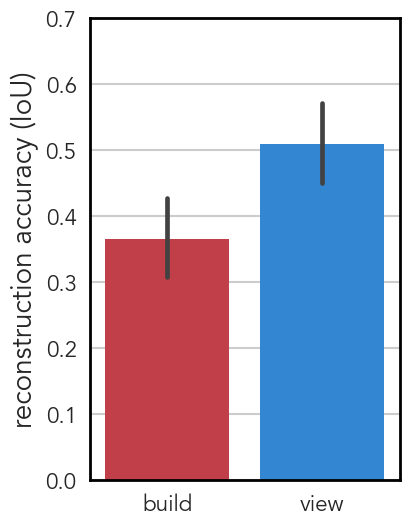

In [485]:
fig = plt.figure(figsize=(4,6))

sns.barplot(df_color_matched_ve,
            x = 'condition',
            hue='condition',
            hue_order = ['build','view'],
            order = ['build','view'],
            palette=palette,
            y = 'score')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.ylim((0,0.7))
plt.title('')
plt.ylabel('reconstruction accuracy (IoU)')
plt.xlabel('')

plt.savefig(plot_dir + 'encode_ve_recall_match_score.pdf', bbox_inches='tight')

In [486]:
df_color_matched_ve.loc[:,'attempted_recall'] = ~df_color_matched_ve.nTower.isna()
df_color_matched_ve.loc[:,'perfectly_recalled'] = df_color_matched_ve.score == 1

In [487]:
df_encode_with_recalls_ve = df_color_matched_ve
df_encode_with_recalls_ve.loc[:,'encode_type'] = 've'
df_encode_with_recalls_ve.to_csv(experiment_results_dir + '/df_encode_with_recalls_ve.csv')

In [497]:
df_color_matched_ve.loc[:,'attempted_recall']

0      False
1       True
2      False
3       True
4       True
       ...  
295     True
296    False
297    False
298    False
299    False
Name: attempted_recall, Length: 300, dtype: bool

In [540]:
ve_all_recall_dist, ve_all_recall_mean = parallel_bootstrap(df_color_matched_ve,
                   bootstrap_column = 'gameID',
                   condition_column = 'encode_type',
                   value_columns = ['attempted_recall'],
                   stat = np.sum
                  )

print('attempted: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_all_recall_mean['ve'], *bootstrapped_ci(ve_all_recall_dist['ve'])))


attempted: ($3.7,\ 95\%\ CI: [3.22,\ 4.16]$)


In [551]:
ve_all_perfect_recall_dist, ve_all_perfect_recall_mean = parallel_bootstrap(df_color_matched_ve,
                   bootstrap_column = 'gameID',
                   condition_column = 'encode_type',
                   value_columns = ['perfectly_recalled'],
                   stat = np.sum
                  )

print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_all_perfect_recall_mean['ve'], *bootstrapped_ci(ve_all_perfect_recall_dist['ve'])))


perfect: ($1.1,\ 95\%\ CI: [0.78,\ 1.46]$)


#### create accuracy score for WM encode type

In [488]:
df_recalls_wm = dfs['wm_re']['recalls'].query('endReason != "give-up"').copy()
df_recalls_wm.loc[:,'nTower'] = df_recalls_wm.trial_index-28

In [489]:
df_recalls_wm.loc[:,'alignedTowerBlocks'] = df_recalls_wm['blocks'].apply(ast.literal_eval).apply(align_tower_left)

In [490]:
# find block map aligned to left
df_recalls_wm.loc[:,'alignedRecallMap'] = \
    df_recalls_wm['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalls_wm.loc[:,'alignedRecallMapHashable'] = df_recalls_wm['alignedRecallMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))


In [491]:
# pad towers with zeros so we can maximize score
max_recall_width = df_recalls_wm['alignedRecallMap'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max score must {} wide'.format(str(max_recall_width + stim_width)))

right_padding = max(0, max_recall_width-6)


max_recall_height = df_recalls_wm['alignedRecallMap'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max score must {} high'.format(str(max_recall_height + stim_height)))

# remove duplicate towers
remove_duplicates = False

if remove_duplicates:
    # consider towers the same if their corresponding block maps are identical
    df_recalls_wm_unique = df_recalls_wm.sort_values(['nTower']).groupby(['gameID', 'alignedRecallMapHashable']).first().reset_index()

    print("removed {} duplicate towers".format(len(df_recalls_wm) - len(df_recalls_wm_unique)))

    

df_recalls_wm.loc[:,'paddedRecallMap'] = df_recalls_wm['alignedRecallMap'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))


widest recalled tower is of width 7
world for calculating max score must 11 wide
tallest recalled tower is of height 8
world for calculating max score must 14 high


In [492]:
df_learn_wm_re = dfs['wm_re']['encode']

In [493]:
# center and pad stimuli
df_learn_wm_re.loc[:,'alignedStimulusMap'] = df_learn_wm_re['stimulus']\
                                                .apply(ast.literal_eval)\
                                                .apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

df_learn_wm_re.loc[:,'alignedStimulusMapHashable'] = df_learn_wm_re['alignedStimulusMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# pad horizontally with zeros  

# add padding to left (max width of recall)
df_learn_wm_re.loc[:,'paddedStimulusMap'] = df_learn_wm_re['alignedStimulusMap'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap)
df_learn_wm_re.loc[:,'paddedStimulusMap'] = df_learn_wm_re['paddedStimulusMap'].apply(lambda x: pad_array(x, right_padding, side="right"))

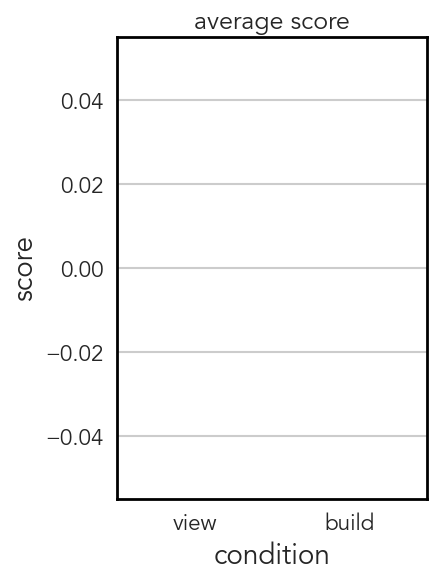

In [494]:
# find stimulus of matching color
df_recalls_wm.loc[:,'color_str'] = df_recalls_wm.color.apply(str)
df_learn_wm_re.loc[:,'color_str'] = df_learn_wm_re.towerColor.apply(str)

df_learn_last_trial_wm = df_learn_wm_re.groupby(['gameID','tower_id_tall']).last().reset_index()

df_color_matched_wm = df_learn_last_trial_wm.merge(df_recalls_wm, 
                                                   how='left', 
                                                   on = ['gameID','color_str'], 
                                                   suffixes=['_learn','_recalled'])

#df_color_matched.rename(columns= {'alignedBlockMaps':'target_block_map'})

df_color_matched_wm.loc[:,'score'] = 0
fig = plt.figure(figsize=(4,6))

sns.barplot(df_color_matched_wm,
            x = 'condition',
            hue='condition',
            palette=palette,
            y = 'score')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.title('average score')
df_color_matched_wm.loc[~df_color_matched_wm.paddedRecallMap.isna(), 'score'] = \
    df_color_matched_wm.loc[~df_color_matched_wm.paddedRecallMap.isna()].apply(\
            lambda row: best_score(row['paddedStimulusMap'], row['paddedRecallMap'])[0], 
            axis=1)

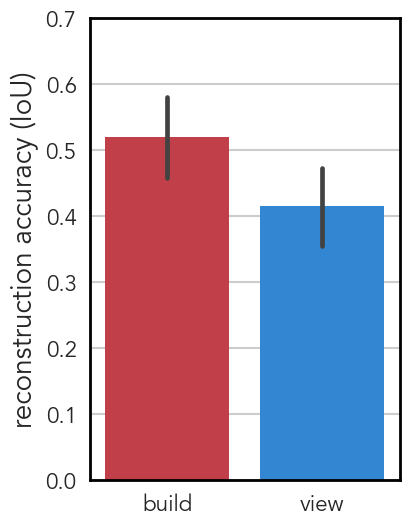

In [495]:
fig = plt.figure(figsize=(4,6))

sns.barplot(df_color_matched_wm,
            x = 'condition',
            hue='condition',
            hue_order = ['build','view'],
            order = ['build','view'],
            palette=palette,
            y = 'score')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.ylim((0,0.7))
    
plt.title('')
plt.ylabel('reconstruction accuracy (IoU)')
plt.xlabel('')

plt.savefig(plot_dir + 'encode_wm_recall_match_score.pdf', bbox_inches='tight')

In [496]:
# diff between condition,


# sns.pointplot(data = df_color_matched_wm,
#                 y = "score",
#                 x = "condition",
#                 hue = "gameID",
#                 order=["view","build"],
#                 alpha=0.3
#              )

# plt.title('score between condition, by participant')

# plt.legend([],[], frameon=False)

In [547]:
df_color_matched_wm.loc[:,'attempted_recall'] = ~df_color_matched_wm.nTower.isna()
df_color_matched_wm.loc[:,'perfectly_recalled'] = df_color_matched_wm.score == 1

In [548]:
df_encode_with_recalls_wm = df_color_matched_wm
df_encode_with_recalls_wm.loc[:,'encode_type'] = 'wm'
df_encode_with_recalls_wm.to_csv(experiment_results_dir + '/df_encode_with_recalls_wm.csv')

In [550]:
wm_all_recall_dist, wm_all_recall_mean = parallel_bootstrap(df_color_matched_wm,
                   bootstrap_column = 'gameID',
                   condition_column = 'encode_type',
                   value_columns = ['attempted_recall'],
                   stat = np.sum
                  )

print('attempted: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_all_recall_mean['wm'], *bootstrapped_ci(wm_all_recall_dist['wm'])))


attempted: ($3.86,\ 95\%\ CI: [3.34,\ 4.38]$)


In [549]:
wm_all_perfect_recall_dist, wm_all_perfect_recall_mean = parallel_bootstrap(df_color_matched_wm,
                   bootstrap_column = 'gameID',
                   condition_column = 'encode_type',
                   value_columns = ['perfectly_recalled'],
                   stat = np.sum
                  )

print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_all_perfect_recall_mean['wm'], *bootstrapped_ci(wm_all_perfect_recall_dist['wm'])))


perfect: ($1.28,\ 95\%\ CI: [0.86,\ 1.7]$)


### combine data from VE and WM

In [558]:
df_encode_with_recalls_both.loc[:,'all'] = 'all'
wm_both_perfect_recall_dist, wm_both_perfect_recall_mean = parallel_bootstrap(df_encode_with_recalls_both,
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['attempted_recall'],
                   stat = np.sum
                  )

print('attempted: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['all'], *bootstrapped_ci(wm_both_perfect_recall_dist['all'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

attempted: ($3.78,\ 95\%\ CI: [3.44,\ 4.11]$)


In [474]:
df_encode_with_recalls_both = pd.concat([df_encode_with_recalls_wm, df_encode_with_recalls_ve], ignore_index=True)
df_encode_with_recalls_both.to_csv(experiment_results_dir + '/df_encode_with_recalls_both.csv')

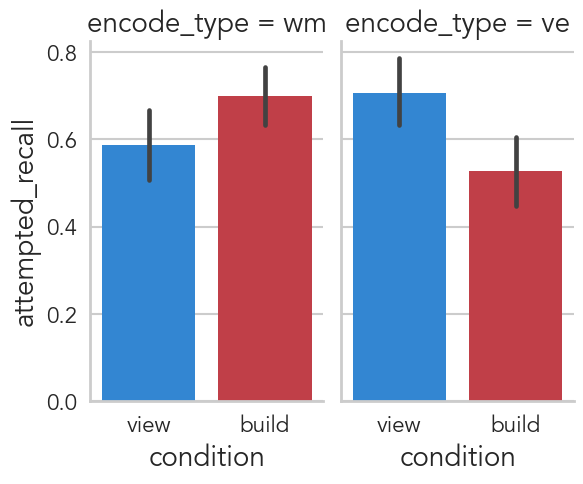

In [475]:
# fig = plt.figure(figsize=(4,6))

fac = sns.catplot(df_encode_with_recalls_both,
            col = 'encode_type',
            x = 'condition',
            hue='condition',
            y = 'attempted_recall',
            palette=palette,
            kind = 'bar',
            aspect = 0.6,
            legend = None
           )


# for ax in fac.axes.flat:
#     for spine in ax.spines.values():
#         spine.set_zorder(1)
#         spine.set_color('black')


## Working memory task performance

#### match-to-sample

In [666]:
dfs['wm_on']['encode'].loc[:,'decode_type'] = 'recog'
dfs['wm_re']['encode'].loc[:,'decode_type'] = 'recall'

In [667]:
df_m2s = pd.concat([dfs['wm_on']['encode'].query('trial_type == "block-tower-match-to-sample"'),
                    dfs['wm_re']['encode'].query('trial_type == "block-tower-match-to-sample"')],
                    ignore_index = True)

In [668]:
df_m2s.loc[:,'all'] = 'all'

In [669]:
m2s_acc_dist, m2s_acc_mean = parallel_bootstrap(df_m2s,
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['correct'],
                   stat = np.mean
                  )

print('(${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean['all'], *bootstrapped_ci(m2s_acc_dist['all'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

($0.891,\ 95\%\ CI: [0.856,\ 0.926]$)


In [670]:
m2s_acc_dist_ve, m2s_acc_mean_ve = parallel_bootstrap(df_m2s.query('decode_type == "recog"'),
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['correct'],
                   stat = np.mean
                  )

print('recog (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_ve['all'], *bootstrapped_ci(m2s_acc_dist_ve['all'])))
# print('wm (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean['wm *bootstrapped_ci(m2s_acc_dist['wm'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

recog ($0.915,\ 95\%\ CI: [0.863,\ 0.958]$)


In [671]:
m2s_acc_dist_wm, m2s_acc_mean_wm = parallel_bootstrap(df_m2s.query('decode_type == "recall"'),
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['correct'],
                   stat = np.mean
                  )

print('recall (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_wm['all'], *bootstrapped_ci(m2s_acc_dist_wm['all'])))
# print('wm (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean['wm *bootstrapped_ci(m2s_acc_dist['wm'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

recall ($0.867,\ 95\%\ CI: [0.813,\ 0.917]$)


<Axes: xlabel='decode_type', ylabel='correct'>

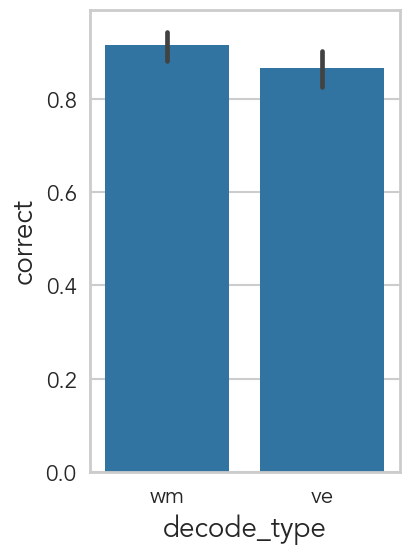

In [607]:
sns.barplot(df_m2s,
           y='correct',
           x='decode_type')

#### compare M2S accuracy with recog accuracy

#### compare M2S accuracy with recall accuracy

#### Build from memory

In [ ]:
# need to calculate accuracy as not saved

In [678]:
df_bfm = pd.concat([dfs['wm_on']['encode'].query('trial_type == "block-tower-building-undo-nostim"'),
                    dfs['wm_re']['encode'].query('trial_type == "block-tower-building-undo-nostim"')],
                    ignore_index = True)
df_bfm['all'] = 'all'

In [679]:
def build_from_memory_score(row):
    target = utils.worldify(ast.literal_eval(row.stimulus)['blocks']).block_map
    reconstruction = 1-np.rot90((np.array(ast.literal_eval(row.discreteWorld))*1))

    pad_right = reconstruction.shape[1] - target.shape[1]
    pad_top = reconstruction.shape[0] - target.shape[0]
    
    padded_target = np.pad(target, ((pad_top, 0), (0, pad_right)), mode='constant')
    
    return best_score(reconstruction, padded_target)[0]

In [680]:
df_bfm['bfm_score'] = df_bfm.apply(build_from_memory_score, axis = 1)

<Axes: xlabel='decode_type', ylabel='bfm_score'>

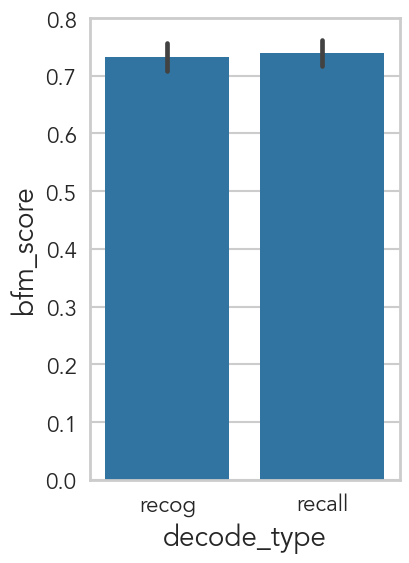

In [681]:
sns.barplot(df_bfm,
           y='bfm_score',
           x='decode_type')

In [682]:
m2s_acc_dist_ve, m2s_acc_mean_ve = parallel_bootstrap(df_bfm.query('decode_type == "recog"'),
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['bfm_score'],
                   stat = np.mean
                  )

print('recog (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_ve['all'], *bootstrapped_ci(m2s_acc_dist_ve['all'])))
# print('wm (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean['wm *bootstrapped_ci(m2s_acc_dist['wm'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

recog ($0.733,\ 95\%\ CI: [0.688,\ 0.774]$)


In [683]:
m2s_acc_dist_wm, m2s_acc_mean_wm = parallel_bootstrap(df_bfm.query('decode_type == "recall"'),
                   bootstrap_column = 'gameID',
                   condition_column = 'all',
                   value_columns = ['bfm_score'],
                   stat = np.mean
                  )

print('recall (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_wm['all'], *bootstrapped_ci(m2s_acc_dist_wm['all'])))
# print('wm (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean['wm *bootstrapped_ci(m2s_acc_dist['wm'])))
# print('perfect: (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_both_perfect_recall_mean['wm'], *bootstrapped_ci(wm_both_perfect_recall_dist['wm'])))

recall ($0.739,\ 95\%\ CI: [0.7,\ 0.778]$)


In [687]:
m2s_acc_dist_ve_reps, m2s_acc_mean_ve_reps = parallel_bootstrap(df_bfm.query('decode_type == "recog"'),
                   bootstrap_column = 'gameID',
                   condition_column = 'rep',
                   value_columns = ['bfm_score'],
                   stat = np.mean
                  )

print('rep 1 (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_ve_reps[1.0], *bootstrapped_ci(m2s_acc_dist_ve_reps[1.0])))
print('rep 2 (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(m2s_acc_mean_ve_reps[2.0], *bootstrapped_ci(m2s_acc_dist_ve_reps[2.0])))
print(p_val(m2s_acc_dist_ve_reps[1.0], m2s_acc_dist_ve_reps[2.0]))

rep 1 ($0.68,\ 95\%\ CI: [0.635,\ 0.724]$)
rep 2 ($0.785,\ 95\%\ CI: [0.736,\ 0.831]$)
1.0


#### compare bfm accuracy with recog accuracy

#### compare bfm accuracy with recall accuracy